In [336]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [337]:
#### Preprocecing ###

In [338]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [339]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [340]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [341]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]

In [342]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]

In [343]:
removed = recovered + death

In [344]:
### Data Preparation ###

In [345]:
S = confirmed.values
R = removed.values
L=5

In [346]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L': L, 'S': S, 'R': R}

In [347]:
### Model ###

In [348]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6697c03e940e8c41baf7bf7f8f621636 NOW.


In [349]:
# Train the model and generate samples
fit = sm.sampling(data=data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [350]:
### Simulation and Visualization functions ###

In [351]:
T = S.shape[0]
N = S.shape[1]
epoch = pd.to_datetime('2020-01-22')

In [352]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    cumulative_list = [confirmed.loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    infected_list = [(confirmed - removed).loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    for d in range(horizen):
        I = infected_list[-L] @ c * (1 - cumulative_list[-L] / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.clip(I, 0, cumulative - recovered)
        recovered = recovered + a * (cumulative_list[-1] - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.clip(recovered, 0, cumulative)
        infected_list.append(cumulative - recovered)
        cumulative_list.append(cumulative)
        
    infected = pd.DataFrame(infected_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected

In [353]:
def draw_infected(fit, start, horizen, country):
    a = fit['a']
    p = fit['p']
    c = fit['c']
    sigma_S = fit['sigma_S']
    sigma_R = fit['sigma_R']
    np.random.shuffle(a)
    np.random.shuffle(p)
    np.random.shuffle(c)
    np.random.shuffle(sigma_S)
    np.random.shuffle(sigma_R)
    data = pd.DataFrame()
    for i in range(1000):
        infected = simulate(a[i], p[i], c[i], sigma_S[i], sigma_R[i], start, horizen)
        data = pd.concat([data, infected[country]], axis=1)
    graph = pd.DataFrame(index=pd.date_range(epoch - pd.Timedelta(days=L), 
                                             start + pd.Timedelta(days=horizen), freq='D'))
    real = (confirmed - removed)[country]
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2)

In [354]:
### Validation ###

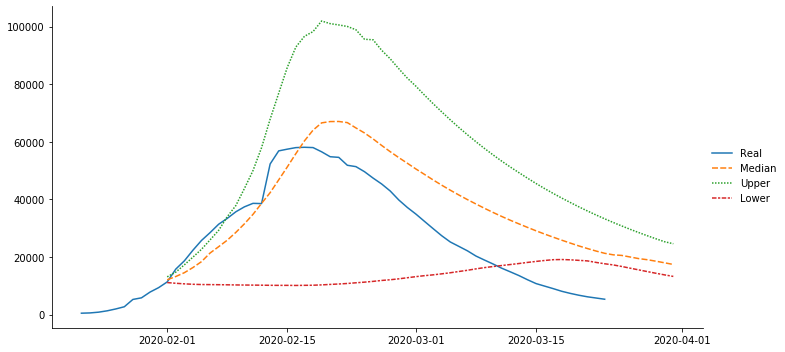

In [355]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

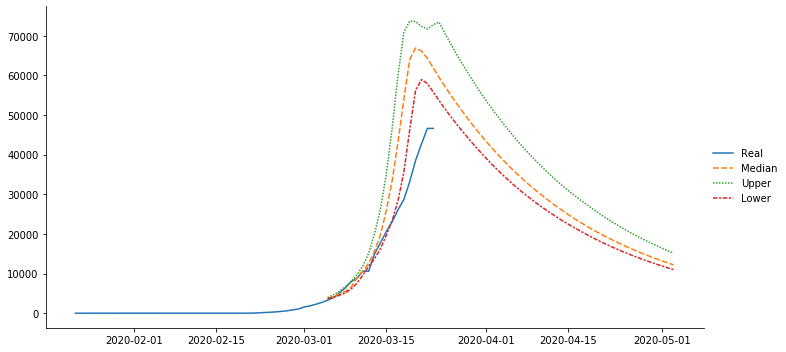

In [356]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

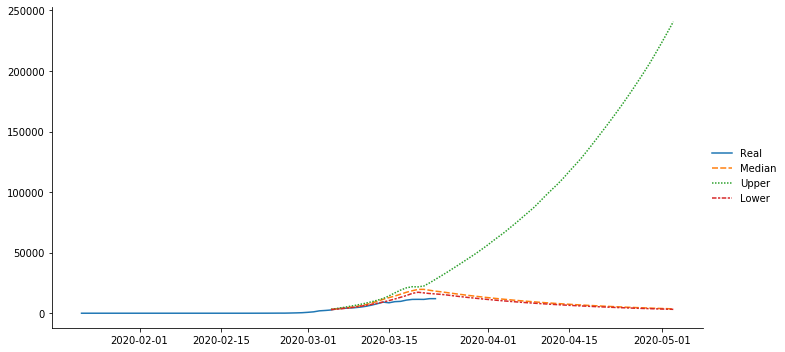

In [357]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

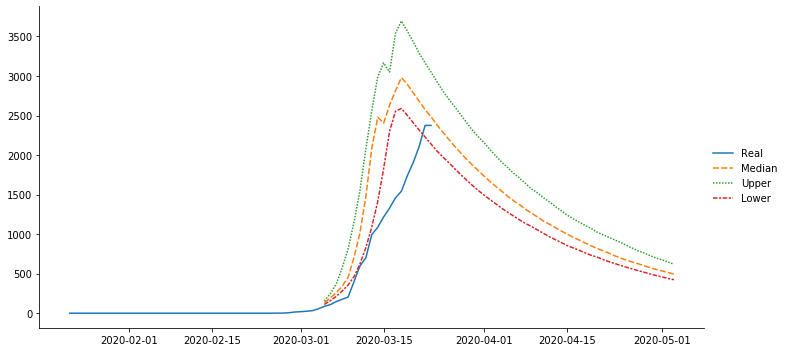

In [358]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

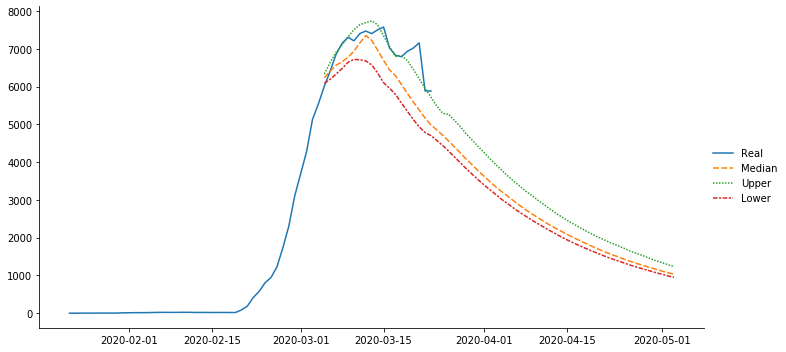

In [359]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

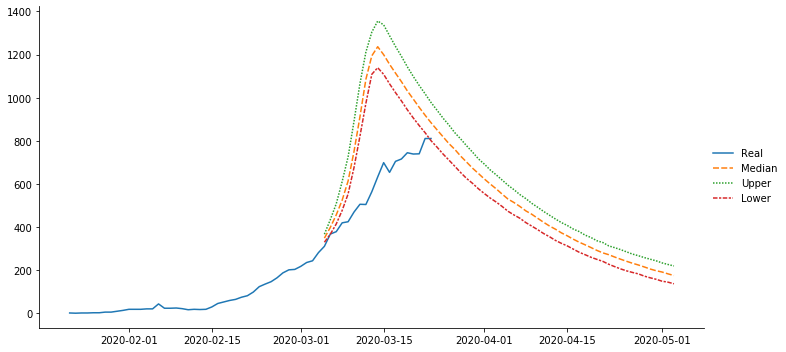

In [360]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

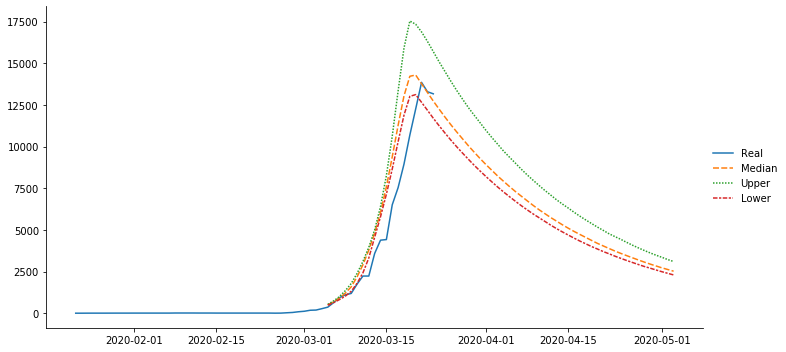

In [361]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

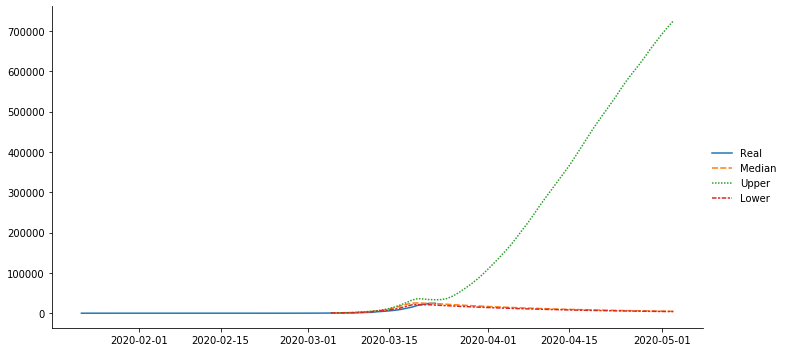

In [362]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

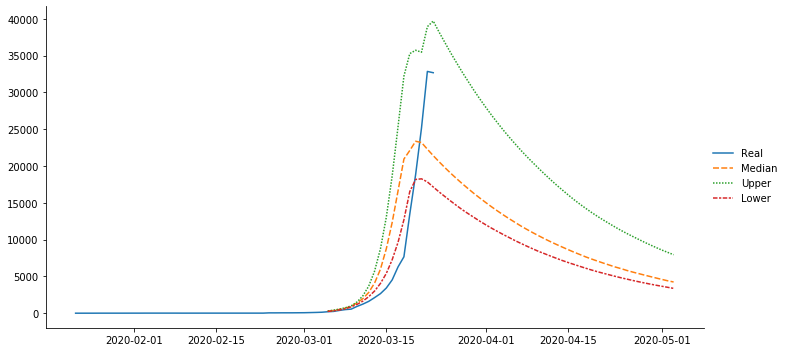

In [363]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [364]:
### Prediction ###

In [397]:
recent = confirmed.index[-1]


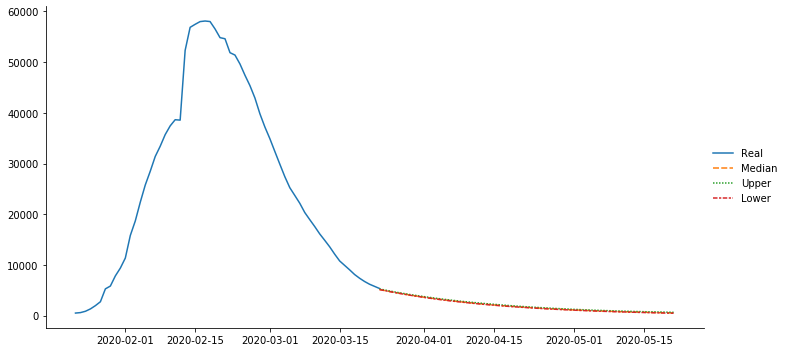

In [398]:
draw_infected(fit, recent, 60, 'China')

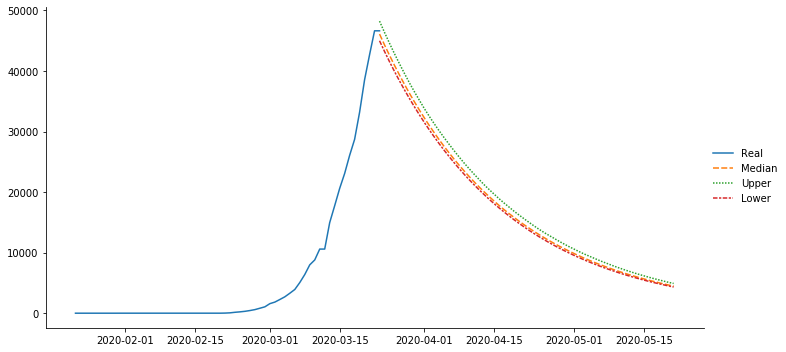

In [399]:
draw_infected(fit, recent, 60, 'Italy')

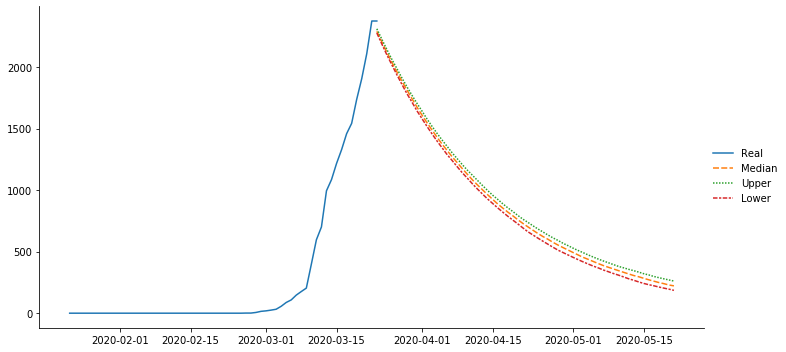

In [400]:
draw_infected(fit, recent, 60, 'Norway')

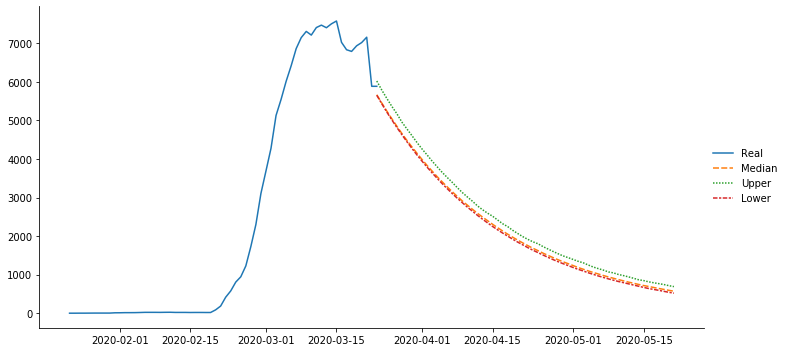

In [401]:
draw_infected(fit, recent, 60, 'Korea, South')

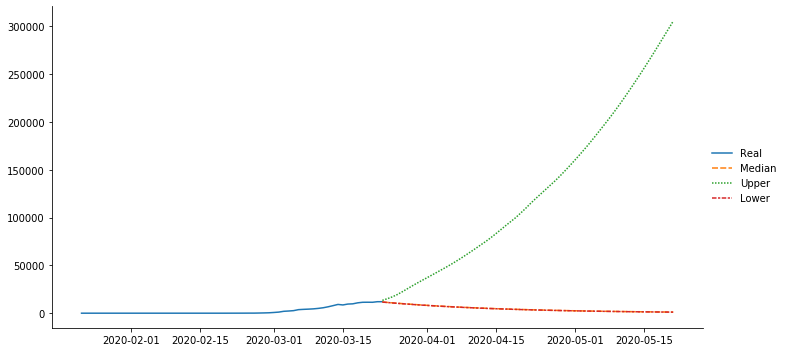

In [402]:
draw_infected(fit, recent, 60, 'Iran')

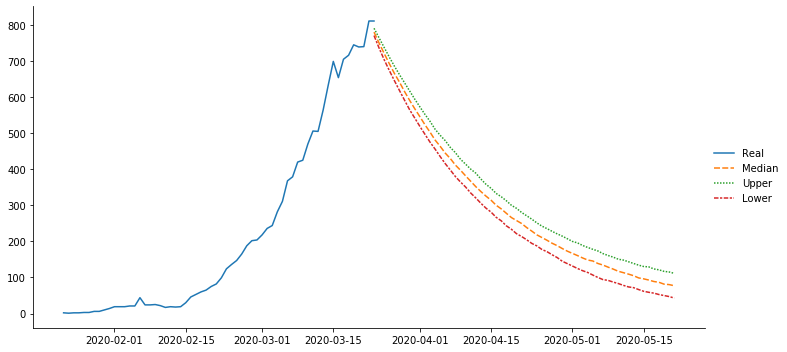

In [403]:
draw_infected(fit, recent, 60, 'Japan')

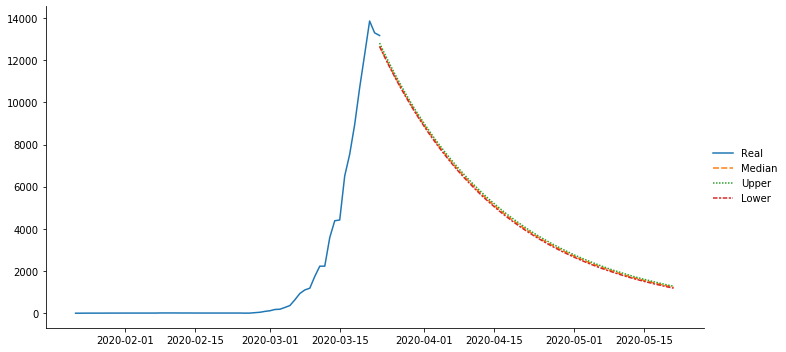

In [404]:
draw_infected(fit, recent, 60, 'France')

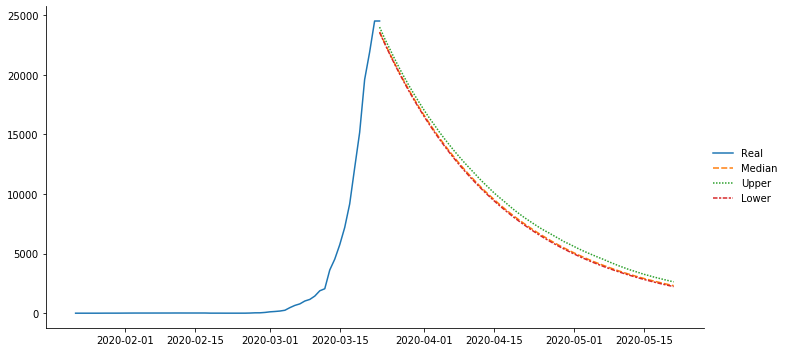

In [405]:
draw_infected(fit, recent, 60, 'Germany')

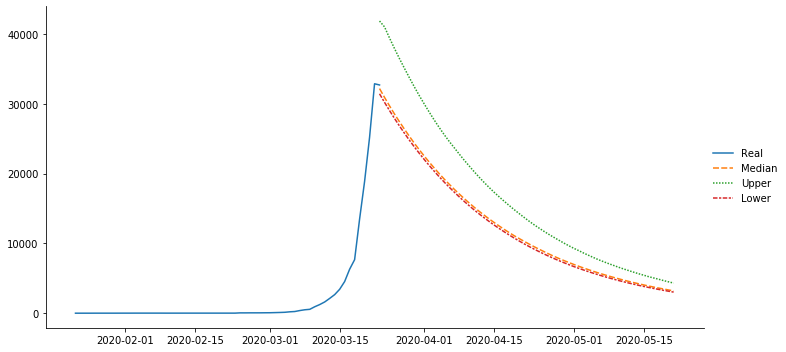

In [406]:
draw_infected(fit, recent, 60, 'US')

In [407]:
def draw_infected_world(fit, start, horizen):
    a = fit['a']
    p = fit['p']
    c = fit['c']
    sigma_S = fit['sigma_S']
    sigma_R = fit['sigma_R']
    np.random.shuffle(a)
    np.random.shuffle(p)
    np.random.shuffle(c)
    np.random.shuffle(sigma_S)
    np.random.shuffle(sigma_R)
    data = pd.DataFrame()
    for i in range(1000):
        infected = simulate(a[i], p[i], c[i], sigma_S[i], sigma_R[i], start, horizen)
        data = pd.concat([data, infected.sum(axis=1)], axis=1)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed).sum(axis=1)
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);

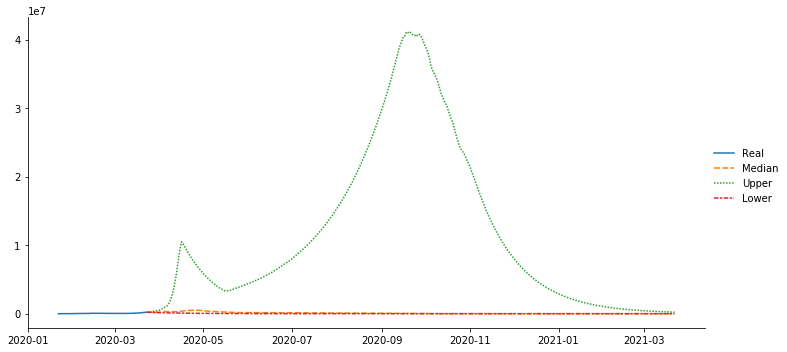

In [408]:
draw_infected_world(fit, recent, 365)

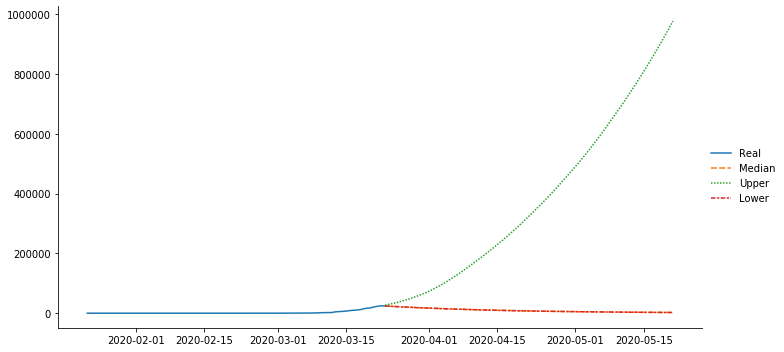

In [409]:
draw_infected(fit, recent, 60, 'Spain')

In [410]:
confirmed.columns

Index(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'China',
       'Czechia', 'Denmark', 'France', 'Germany', 'Iran', 'Israel', 'Italy',
       'Japan', 'Korea, South', 'Malaysia', 'Netherlands', 'Norway',
       'Portugal', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'US',
       'United Kingdom'],
      dtype='object', name='Country/Region')

In [411]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': False}

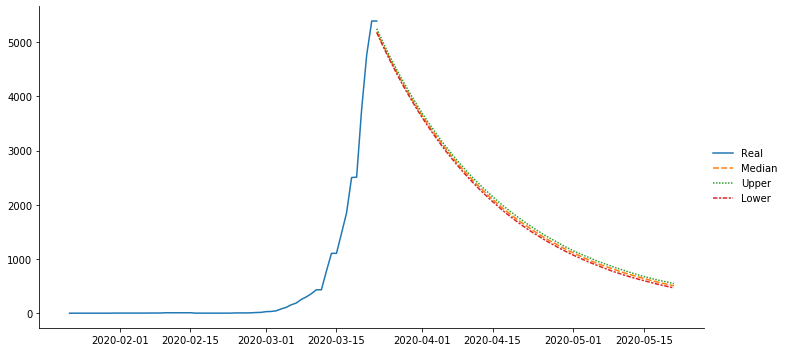

In [412]:
draw_infected(fit, recent, 60, 'United Kingdom')

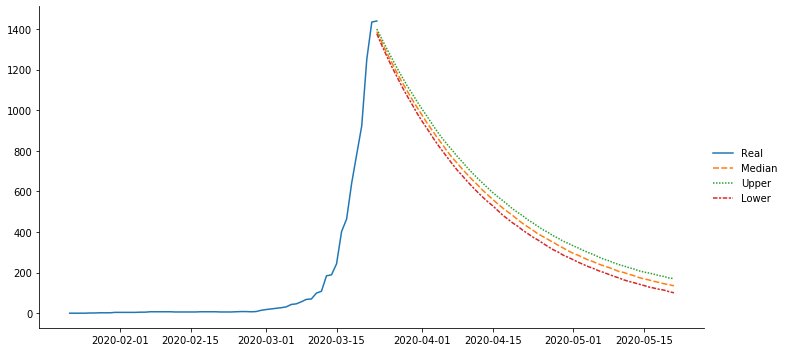

In [413]:
draw_infected(fit, recent, 60, 'Canada')

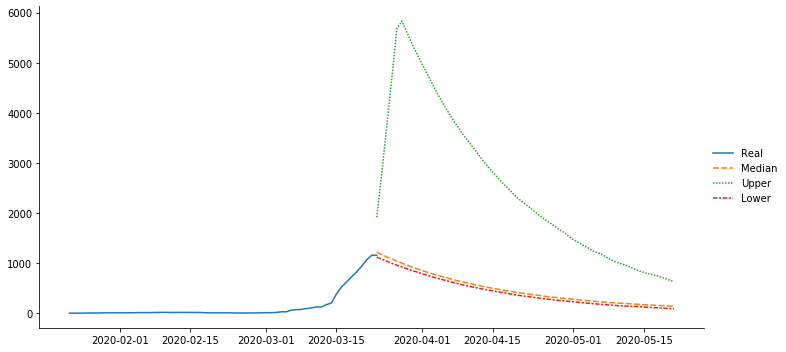

In [414]:
draw_infected(fit, recent, 60, 'Malaysia')